# import modules

In [1]:
### data processing imports
import numpy as np
import os
import sys
sys.path.insert(1,'../')

import h5py
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.spatial import ConvexHull, Delaunay
from scipy.stats import iqr
from AFL.automation.APIServer.Client import Client
import xarray as xr
import seaborn as sns
from os.path import basename
import pathlib

base_path = pathlib.Path('./')
### Imports for Similarity Metrics
from AFL.agent import xarray_extensions
from AFL.agent import reduce_usaxs

from AFL.agent.AgentClient import AgentClient
from AFL.agent import Metric,PhaseLabeler,AcquisitionFunction,GaussianProcess,HscedGaussianProcess,UCB_AcquisitionFunction

from scipy.spatial.distance import pdist

import gpflow
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

2023-05-28 14:09:23.132613: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 14:09:23.176854: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
%load_ext autoreload
%autoreload 2

## Data loading
- this data set contains two separate using the same components but with extended grids

### Grid 1 load

0 P188-Bz-Ph_10-0.0-0.0_mgml.h5
1 P188-Bz-Ph_10-0.0-12.0_mgml.h5
2 P188-Bz-Ph_10-0.0-15.0_mgml.h5
3 P188-Bz-Ph_10-0.0-3.0_mgml.h5
4 P188-Bz-Ph_10-0.0-6.0_mgml.h5
5 P188-Bz-Ph_10-0.0-9.0_mgml.h5
6 P188-Bz-Ph_10-11.25-0.0_mgml.h5
7 P188-Bz-Ph_10-11.25-12.0_mgml.h5
8 P188-Bz-Ph_10-11.25-15.0_mgml.h5
9 P188-Bz-Ph_10-11.25-3.0_mgml.h5
10 P188-Bz-Ph_10-11.25-6.0_mgml.h5
11 P188-Bz-Ph_10-11.25-9.0_mgml.h5
12 P188-Bz-Ph_10-15.0-0.0_mgml.h5
13 P188-Bz-Ph_10-15.0-12.0_mgml.h5
14 P188-Bz-Ph_10-15.0-15.0_mgml.h5
15 P188-Bz-Ph_10-15.0-3.0_mgml.h5
16 P188-Bz-Ph_10-15.0-6.0_mgml.h5
17 P188-Bz-Ph_10-15.0-9.0_mgml.h5
18 P188-Bz-Ph_10-3.75-0.0_mgml.h5
19 P188-Bz-Ph_10-3.75-12.0_mgml.h5
20 P188-Bz-Ph_10-3.75-15.0_mgml.h5
21 P188-Bz-Ph_10-3.75-3.0_mgml.h5
22 P188-Bz-Ph_10-3.75-6.0_mgml.h5
23 P188-Bz-Ph_10-3.75-9.0_mgml.h5
24 P188-Bz-Ph_10-7.5-0.0_mgml.h5
25 P188-Bz-Ph_10-7.5-12.0_mgml.h5
26 P188-Bz-Ph_10-7.5-15.0_mgml.h5
27 P188-Bz-Ph_10-7.5-3.0_mgml.h5
28 P188-Bz-Ph_10-7.5-6.0_mgml.h5
29 P188-Bz-Ph_10-7.

  0%|          | 0/2601 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 17.19it/s]


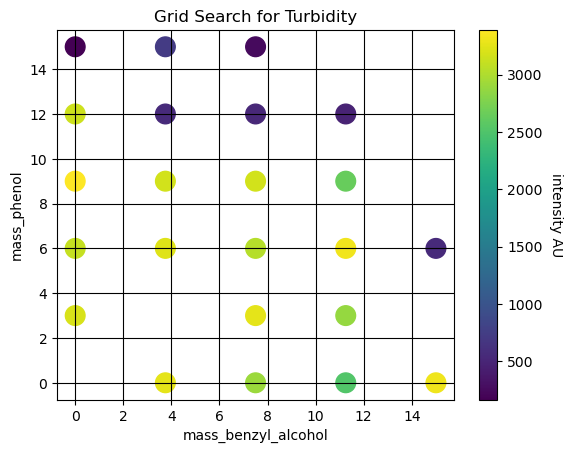

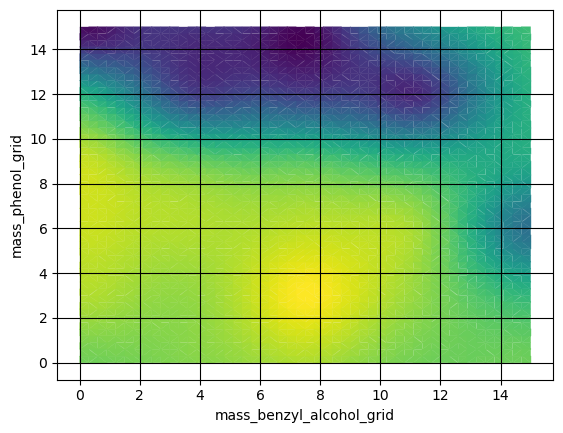

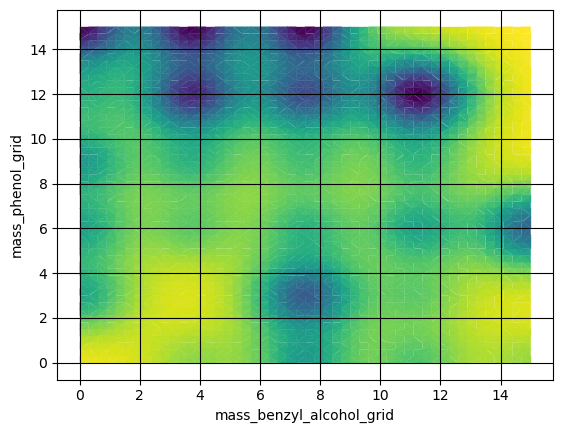

In [3]:
#correct labeling
ph = np.linspace(0,15,6)
ba = np.linspace(0,15,5)
ba,ph = np.meshgrid(ba,ph)
ba,ph = ba.ravel(),ph.ravel()

original_labeling_grid = []
for i in range(len(ba)):
    original_labeling_grid.append(f'P188-Bz-Ph_10-{np.round(ba[i],2)}-{np.round(ph[i],2)}_mgml.h5')
original_labeling_grid = sorted(original_labeling_grid)
samples_made = np.copy(original_labeling_grid).tolist()
for idx, i in enumerate(samples_made):
    print(idx,i)
# for i in [29,28,24,19,0]:
for i in [17,14,13,8,0]:
    del samples_made[i]
# for idx, i in enumerate(samples_made):
#     print(idx,i)
ds_list = []
fnames = []
comps = []
ds_all_1 = xr.Dataset()
for idx, fname in enumerate(sorted(base_path.glob('230414_P188_Autoprepared_series/*h5'))):
    
#     if os.path.basename(fname) == 'P188-Bz-Ph_10-3.75-3.0_mgml.h5':
#         print('bad data')
#     else:
#         print('good data')
#         print(fname)
    with h5py.File(fname,'r') as h5:
        key = list(h5.keys())[0]
        data = h5[key][()][:,:,1:]
        ds_static_list = []
        timed_sample = []
        # fnames.append(basename(fname))
        # concentrations = np.array(basename(fname).split("_")[1].split('-'),dtype='float')
        fnames.append(samples_made[idx])
        concentrations = np.array(samples_made[idx].split("_")[1].split('-'),dtype='float')
        if samples_made[idx] in ['P188-Bz-Ph_10-3.75-3.0_mgml.h5', 'P188-Bz-Ph_10-15.0-3.0_mgml.h5']:
            pass
        else:
            comps.append(concentrations)
            for point in data:
                timed_sample.append(point[1])

            λ = point[0]
            timed_sample = np.array(timed_sample)
            da = xr.DataArray(timed_sample, dims=['time','wavelength'],
                                                  coords={'time':np.linspace(0,0.1*len(timed_sample),len(timed_sample)),
                                                         'wavelength':λ},  name='raw')
            da.attrs['units'] = 'AU'
            da.wavelength.attrs['units'] = 'nm'
            da.time.attrs['units'] = 's'

            ds = xr.Dataset()
            ds['raw'] = da

            maxima  = ds['raw'].max(axis=1)
            max_IQR = iqr(maxima)
            median  = np.median(maxima)
            filt_criteria = [(maxima >= median-max_IQR) & (maxima <= median+max_IQR)]
            ds['filtered_data_iqr']  = ds['raw'].where((maxima >= median-max_IQR) & (maxima <= median+max_IQR))

            μ_ts = maxima.mean()
            σ_ts = maxima.std()
            ds['mean_of_maxima']  = μ_ts
            ds['std_of_maxima'] = σ_ts
            ds['filtered_data_1std'] = ds['raw'].where((maxima >= μ_ts-σ_ts) & (maxima <= μ_ts+σ_ts))
            ds['maxima'] = maxima
            ds['IQR'] = ('sample',[max_IQR])
            ds['median'] = ('sample',[median])

            ds['fname'] = ('sample',[basename(fname)])
            ds['mass_P188'] = ('sample',[concentrations[0]])
            ds['mass_benzyl_alcohol'] = ('sample',[concentrations[1]])
            ds['mass_phenol'] = ('sample',[concentrations[2]])

            ds_list.append(ds)
        
comps = np.array(comps)
ds_all_1 = xr.concat(ds_list,dim='sample')
sm = ds_all_1[['mass_P188', 'mass_benzyl_alcohol','mass_phenol']].to_array('solutes').transpose('sample',...)
ds_all_1['solute_masses'] = sm


# norm = mcolors.LogNorm(vmin=100, vmax=ds_all_1['median'].max())
sc  = ds_all_1.afl.comp.plot_scatter(['mass_benzyl_alcohol','mass_phenol'],labels='mean_of_maxima',discrete_labels=False, s=200);#,norm=norm);

cbar = plt.colorbar(sc)
cbar.set_label(label='intensity AU',rotation=270,labelpad=15)
plt.title('Grid Search for Turbidity')
# plt.savefig('230414_Turbidity_DataSeries.png',dpi=300)

ds_all_1.attrs['components'] = ['mass_benzyl_alcohol','mass_phenol']
ds_all_1.attrs['AL_data'] = 'mean_of_maxima'
ds_all_1.attrs['input_uncert'] = 'std_of_maxima'
ds_all_1.attrs['mass_benzyl_alcohol_range'] = (0,15)
ds_all_1.attrs['mass_phenol_range'] = (0,15)

ds_all_1 = ds_all_1.afl.comp.add_grid(pts_per_row=51,overwrite=True)
# try:
#     ds_merged = ds_merged.afl.comp.add_grid()
# except:
#     pass
kernel = gpflow.kernels.Matern52(variance=0.5,lengthscales=2.0) + gpflow.kernels.White(1e-1)

GPR = HscedGaussianProcess.GPR(
    dataset = ds_all_1,
    inputs = ds_all_1['median'],
    uncertainties=ds_all_1['IQR'],
    kernel=kernel
)
GPR.optimize(15,progress_bar=True)

result = GPR.predict(ds_all_1.attrs['components_grid'])
ds_all_1['GP_mean'] = ('grid',result['mean'].squeeze())
ds_all_1['GP_var'] = ('grid',result['var'].squeeze())
ds_all_1.afl.comp.plot_surface(ds_all_1.attrs['components_grid'],labels='GP_mean')
ds_all_1.afl.comp.plot_surface(ds_all_1.attrs['components_grid'],labels='GP_var')

### Grid 2 load

--> Making grid for components ['mass_benzyl_alcohol', 'mass_phenol'] at 51 pts_per_row
{'mass_benzyl_alcohol': {'min': 0, 'max': 15, 'steps': 51}, 'mass_phenol': {'min': 0, 'max': 15, 'steps': 51}}


  0%|          | 0/2601 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 19.35it/s]


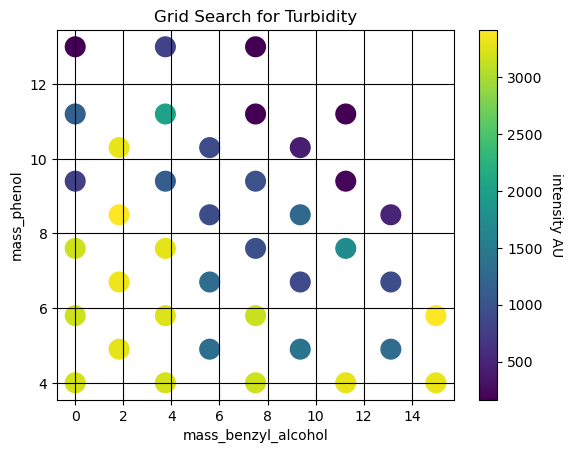

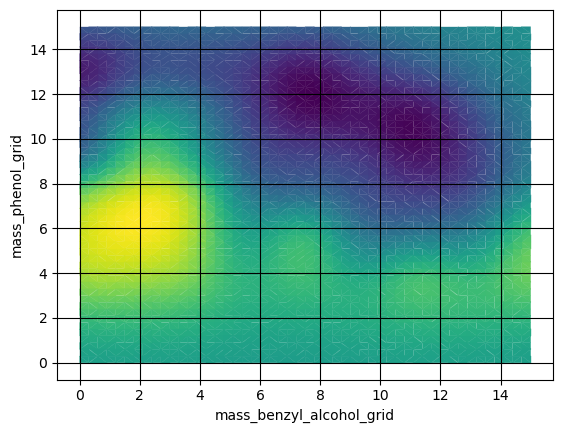

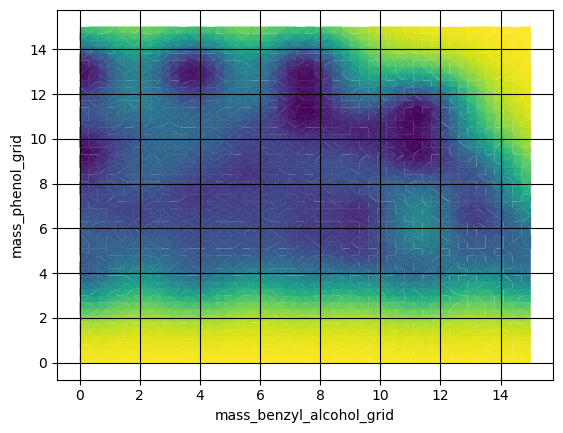

In [4]:
ds_list = []
fnames = []
comps = []
ds_all_2 = xr.Dataset()
for fname in sorted(base_path.glob('230417_P188_Autoprepared_Series/*h5')):
    if os.path.basename(fname) == 'P188-Bz-Ph_10-11.25-5.8_mgml.h5':
        pass
    else:
    # print(fname)
        with h5py.File(fname,'r') as h5:
            key = list(h5.keys())[0]
            data = h5[key][()][:,:,1:]
            ds_static_list = []
            timed_sample = []
            fnames.append(basename(fname))
            concentrations = np.array(basename(fname).split("_")[1].split('-'),dtype='float')
            comps.append(concentrations)
            for point in data:
                timed_sample.append(point[1])

            λ = point[0]
            timed_sample = np.array(timed_sample)
            da = xr.DataArray(timed_sample, dims=['time','wavelength'],
                                                  coords={'time':np.linspace(0,0.1*len(timed_sample),len(timed_sample)),
                                                         'wavelength':λ},  name='raw')
            da.attrs['units'] = 'AU'
            da.wavelength.attrs['units'] = 'nm'
            da.time.attrs['units'] = 's'





            ds = xr.Dataset()
            # ds['raw'] = xr.concat(ds_static_list,dim='point')
            ds['raw'] = da

            maxima  = ds['raw'].max(axis=1)
            max_IQR = iqr(maxima)
            median  = np.median(maxima)
            filt_criteria = [(maxima >= median-max_IQR) & (maxima <= median+max_IQR)]
            ds['filtered_data_iqr']  = ds['raw'].where((maxima >= median-max_IQR) & (maxima <= median+max_IQR))

            μ_ts = maxima.mean()
            σ_ts = maxima.std()
            ds['mean_of_maxima']  = μ_ts
            ds['std_of_maxima'] = σ_ts
            ds['filtered_data_1std'] = ds['raw'].where((maxima >= μ_ts-σ_ts) & (maxima <= μ_ts+σ_ts))
            ds['maxima'] = maxima
            ds['IQR'] = ('sample',[max_IQR])
            ds['median'] = ('sample',[median])

            ds['fname'] = ('sample',[basename(fname)])
            ds['mass_P188'] = ('sample',[concentrations[0]])
            ds['mass_benzyl_alcohol'] = ('sample',[concentrations[1]])
            ds['mass_phenol'] = ('sample',[concentrations[2]])

            ds_list.append(ds)
        
comps = np.array(comps)
ds_all_2 = xr.concat(ds_list,dim='sample')
sm = ds_all_2[['mass_P188', 'mass_benzyl_alcohol','mass_phenol']].to_array('solutes').transpose('sample',...)
ds_all_2['solute_masses'] = sm


# norm = mcolors.LogNorm(vmin=100, vmax=ds_all_2['median'].max())
sc  = ds_all_2.afl.comp.plot_scatter(['mass_benzyl_alcohol','mass_phenol'],labels='mean_of_maxima',discrete_labels=False, s=200);#,norm=norm);

cbar = plt.colorbar(sc)
cbar.set_label(label='intensity AU',rotation=270,labelpad=15)
plt.title('Grid Search for Turbidity')
# plt.savefig('230417_finer_condition_mesh.png',dpi=300)


ds_all_2.attrs['components'] = ['mass_benzyl_alcohol','mass_phenol']
ds_all_2.attrs['AL_data'] = 'mean_of_maxima'
ds_all_2.attrs['input_uncert'] = 'std_of_maxima'
ds_all_2.attrs['mass_benzyl_alcohol_range'] = (0,15)
ds_all_2.attrs['mass_phenol_range'] = (0,15)

ds_all_2 = ds_all_2.afl.comp.add_grid(pts_per_row=51,overwrite=True)
# try:
#     ds_merged = ds_merged.afl.comp.add_grid()
# except:
#     pass
kernel = gpflow.kernels.Matern52(variance=0.5,lengthscales=2.0) + gpflow.kernels.White(1e-1)

GPR = HscedGaussianProcess.GPR(
    dataset = ds_all_2,
    inputs = ds_all_2['median'],
    uncertainties=ds_all_2['IQR'],
    kernel=kernel
)
GPR.optimize(15,progress_bar=True)

result = GPR.predict(ds_all_2.attrs['components_grid'])
ds_all_2['GP_mean'] = ('grid',result['mean'].squeeze())
ds_all_2['GP_var'] = ('grid',result['var'].squeeze())
ds_all_2.afl.comp.plot_surface(ds_all_2.attrs['components_grid'],labels='GP_mean')
ds_all_2.afl.comp.plot_surface(ds_all_2.attrs['components_grid'],labels='GP_var')

### Merge the datasets

--> Making grid for components ['mass_benzyl_alcohol', 'mass_phenol'] at 51 pts_per_row
{'mass_benzyl_alcohol': {'min': 0, 'max': 15, 'steps': 51}, 'mass_phenol': {'min': 0, 'max': 15, 'steps': 51}}


  0%|          | 0/2601 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 16.20it/s]


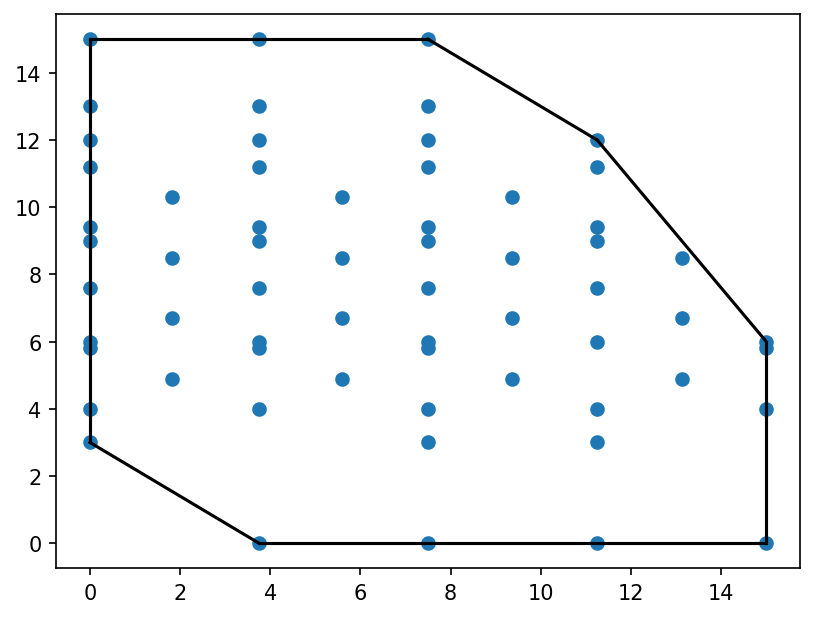

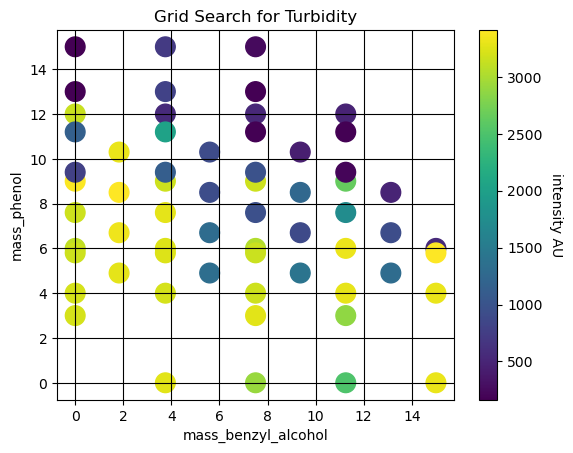

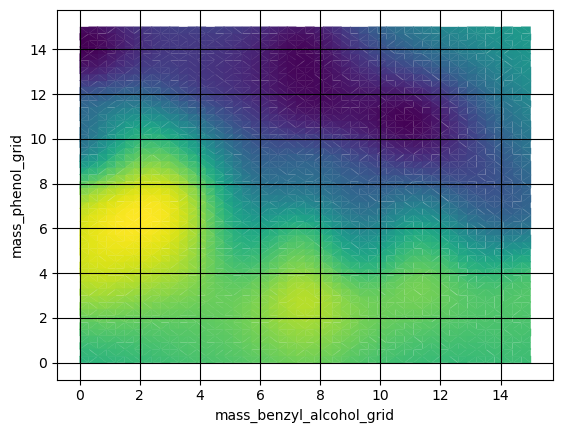

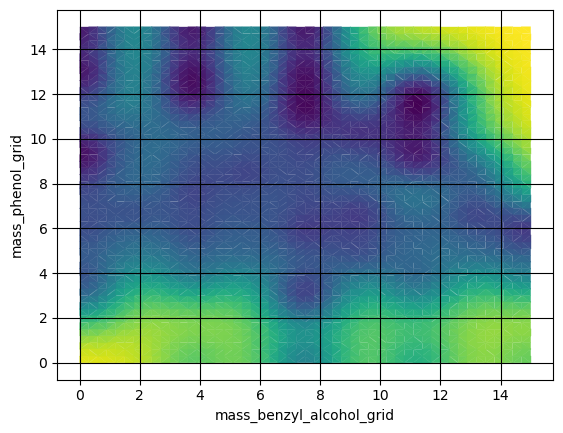

In [5]:

#Ground truth to pull from and to test against
ds_GT = xr.concat([ds_all_1,ds_all_2],dim='sample');

ch = ConvexHull(list(zip(ds_GT['mass_benzyl_alcohol'],ds_GT['mass_phenol'])))
delaunay = Delaunay(list(zip(ds_GT['mass_benzyl_alcohol'],ds_GT['mass_phenol'])))

fig,ax = plt.subplots(dpi=150)

xy = np.array([ds_GT['mass_benzyl_alcohol'],ds_GT['mass_phenol']]).T
ax.scatter(ds_GT['mass_benzyl_alcohol'],ds_GT['mass_phenol'])
for simplex in ch.simplices:
    ax.plot(xy[simplex,0],xy[simplex,1],c='k')


# ds_GT
# ds_GT['mask'] = ('grid',)



sm = ds_GT[['mass_P188', 'mass_benzyl_alcohol','mass_phenol']].to_array('solutes').transpose('sample',...)
ds_GT['solute_masses'] = sm


# norm = mcolors.LogNorm(vmin=100, vmax=ds_all_2['median'].max())
sc  = ds_GT.afl.comp.plot_scatter(['mass_benzyl_alcohol','mass_phenol'],labels='mean_of_maxima',discrete_labels=False, s=200);#,norm=norm);

cbar = plt.colorbar(sc)
cbar.set_label(label='intensity AU',rotation=270,labelpad=15)
plt.title('Grid Search for Turbidity')
# plt.savefig('230417_finer_condition_mesh.png',dpi=300)


ds_GT.attrs['components'] = ['mass_benzyl_alcohol','mass_phenol']
ds_GT.attrs['AL_data'] = 'mean_of_maxima'
ds_GT.attrs['input_uncert'] = 'std_of_maxima'
ds_GT.attrs['mass_benzyl_alcohol_range'] = (0,15)
ds_GT.attrs['mass_phenol_range'] = (0,15)

mask = delaunay.find_simplex(np.array([ds_GT['mass_benzyl_alcohol_grid'],ds_GT['mass_phenol_grid']]).T)>=0

ds_GT = ds_GT.afl.comp.add_grid(pts_per_row=51,overwrite=True)
ds_GT['grid_mask'] = (('grid','sample'),mask)
# try:
#     ds_merged = ds_merged.afl.comp.add_grid()
# except:
#     pass
kernel = gpflow.kernels.Matern52(variance=0.5,lengthscales=2.0) + gpflow.kernels.White(1e-1)

GPR = HscedGaussianProcess.GPR(
    dataset = ds_GT,
    inputs = ds_GT['median'],
    uncertainties=ds_GT['IQR'],
    kernel=kernel
)
GPR.optimize(15,progress_bar=True)

result = GPR.predict(ds_GT.attrs['components_grid'])
ds_GT['GP_mean'] = ('grid',result['mean'].squeeze())
ds_GT['GP_var'] = ('grid',result['var'].squeeze())
ds_GT.afl.comp.plot_surface(ds_GT.attrs['components_grid'],labels='GP_mean')
ds_GT.afl.comp.plot_surface(ds_GT.attrs['components_grid'],labels='GP_var')


# Steps in Active Learning

Goals:
- use both the GP classifier AND the GP regressor to make a decision
- try UCB active learning using the GP mean of the regressor and the uncertainty in the GP classifier to drive decision making. 
- make sure the signs are correct on both lambda and the mean function to sample min or max accordingly



## initialize experiment

In [14]:
#start an experiment dataset and populate with a random point
# pass a randome experimental location from the ground truth dataset into a new one for AL mapping
# ds_AL = xr.concat([ds_GT.sel(sample=np.random.randint(low=0,high=len(ds_GT['sample'])))],dim='sample')
ds_AL = xr.concat([ds_GT.sel(sample=[5,6,13])],dim='sample')
ds_AL = ds_AL.drop_vars(['mass_benzyl_alcohol_grid','mass_phenol_grid','GP_mean','GP_var',])
ds_AL = ds_AL.afl.comp.add_grid(pts_per_row=51,overwrite=True)

#setup the mask from the experimental data to the grid. In principle, this is determined fully by the composition ranges probed

mask = delaunay.find_simplex(np.array([ds_GT['mass_benzyl_alcohol_grid'],ds_GT['mass_phenol_grid']]).T)>=0
ds_AL['grid_mask'] = ('grid',mask)
# ds_AL['mask'] = mask
ds_AL


--> Making grid for components ['mass_benzyl_alcohol', 'mass_phenol'] at 51 pts_per_row
{'mass_benzyl_alcohol': {'min': 0, 'max': 15, 'steps': 51}, 'mass_phenol': {'min': 0, 'max': 15, 'steps': 51}}


  0%|          | 0/2601 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:                   (time: 98, wavelength: 2047, sample: 3,
                               solutes: 3, grid: 2601)
Coordinates:
  * time                      (time) float64 0.0 0.102 0.1021 ... 4.898 4.9 5.0
  * wavelength                (wavelength) float64 181.2 181.5 ... 867.7 867.9
  * solutes                   (solutes) object 'mass_P188' ... 'mass_phenol'
Dimensions without coordinates: sample, grid
Data variables: (12/16)
    raw                       (sample, time, wavelength) float64 111.0 ... 122.0
    filtered_data_iqr         (sample, time, wavelength) float64 111.0 ... 122.0
    mean_of_maxima            (sample) float64 2.51e+03 471.2 548.6
    std_of_maxima             (sample) float64 335.8 2.746 11.68
    filtered_data_1std        (sample, time, wavelength) float64 111.0 ... nan
    maxima                    (sample, time) float64 2.421e+03 ... 535.0
    ...                        ...
    mass_benzyl_alcohol       (sample) float64 11.25 11.25 3.75
    mass_phenol               (sample) float64 0.0 12.0 12.0
    solute_masses             (sample, solutes) float64 10.0 11.25 ... 3.75 12.0
    grid_mask                 (grid) bool False False False ... False False
    mass_benzyl_alcohol_grid  (grid) float64 0.0 0.0 0.0 0.0 ... 15.0 15.0 15.0
    mass_phenol_grid          (grid) float64 0.0 0.3 0.6 0.9 ... 14.4 14.7 15.0
Attributes:
    components:                      ['mass_benzyl_alcohol', 'mass_phenol']
    AL_data:                         mean_of_maxima
    input_uncert:                    std_of_maxima
    mass_benzyl_alcohol_range:       (0, 15)
    mass_phenol_range:               (0, 15)
    components_grid:                 ['mass_benzyl_alcohol_grid', 'mass_pheno...
    mass_benzyl_alcohol_grid_range:  (0, 15)
    mass_phenol_grid_range:          (0, 15)

## set up the similarity metric

- not a bug, but not sure how to handle single measured point. Breaks the similarity thing

In [15]:
# ds_AL['t_avg_scan'] = ds_AL['raw'].mean(dim='time')

In [16]:
ds_AL['t_avg_scan'] = ds_AL['raw'].mean(dim='time')
metric1 = Metric.Similarity('t_avg_scan',  name='t_avg_scan',  params=dict(metric='cosine'))
metric2 = Metric.Similarity('t_avg_scan',  name='t_avg_scan',  params=dict(metric='poly',gamma=1e-4,power=0.5))

metric1.calculate(ds_AL)
metric2.calculate(ds_AL)

metric = Metric.MultiMetric(
    [metric1,metric2],
    combine_by='sum',
    combine_by_powers=[1,1],
    combine_by_coeffs=[1,0],
    constrain_same=None,
    constrain_different=None,
)
metric.calculate(ds_AL)

<Metric:t_avg_scan-t_avg_scan>

Found 2 phases!


[Text(0.5, 1.0, 'maximum intensity'), (-1.0, 16.0), (-1.0, 16.0), None]

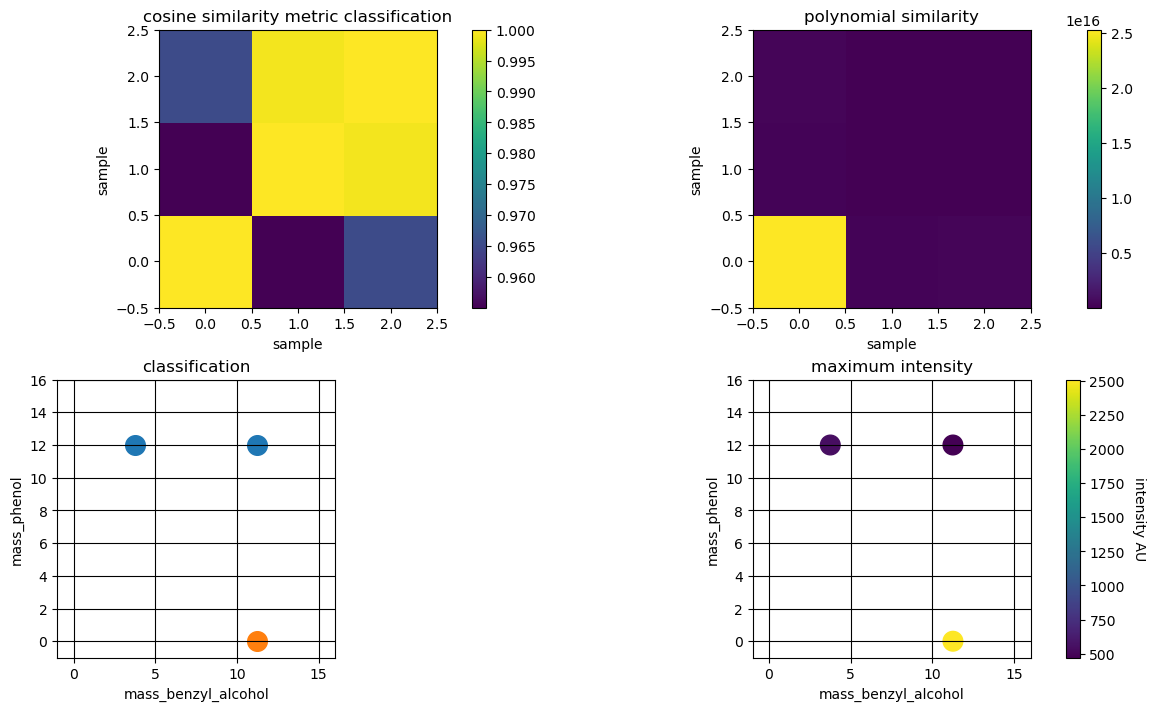

In [83]:
fig,ax = plt.subplots(2,2,figsize=(12,7),constrained_layout=True)
mmap = ax[0][0].imshow(metric1.W,origin='lower')
plt.colorbar(mappable=mmap,ax=ax[0][0])
ax[0][0].set(
    xlabel = "sample",
    ylabel = "sample",
    title = "cosine similarity metric classification"
)

mmap = ax[0][1].imshow(metric2.W,origin='lower')
plt.colorbar(mappable=mmap,ax=ax[0][1])
ax[0][1].set(
    xlabel = "sample",
    ylabel = "sample",
    title = "polynomial similarity"
)

ds_AL['W'] = (('sample_i','sample_j'),metric.W)
ds_AL.attrs['metric'] = str(metric.to_dict())
labeler=PhaseLabeler.SpectralClustering()
# labeler = PhaseLabeler.DBSCAN()
labeler.label(ds_AL)
print(f'Found {labeler.n_phases} phases!')
ds_AL.attrs['n_phases'] = labeler.n_phases
ds_AL['labels'] = ('sample',labeler.labels)

ds_AL.afl.comp.plot_scatter(['mass_benzyl_alcohol','mass_phenol'],labels='labels',discrete_labels=True, s=200,ax=ax[1][0]);#,norm=norm);
ax[1][0].set(
    title = 'classification',
    xlim=(-1,16),
    ylim=(-1,16),
    aspect=ax[0][0].get_aspect()
)

sc  = ds_AL.afl.comp.plot_scatter(['mass_benzyl_alcohol','mass_phenol'],labels='mean_of_maxima',discrete_labels=False, s=200,ax=ax[1][1]);#,norm=norm);
cbar = plt.colorbar(sc,ax=ax[1][1])
cbar.set_label(label='intensity AU',rotation=270,labelpad=15)

ax[1][1].set(
    title = 'maximum intensity',
    xlim=(-1,16),
    ylim=(-1,16),
    aspect=ax[0][0].get_aspect()
)
 

## define the GP classifier and regressor
- The GPR and the GPC look to data based on the specific keyword attributes 'AL_data' or 'n_clusters' etc.


In [62]:
kernel_1 = gpflow.kernels.Matern32(variance=0.5,lengthscales=1.0) 
GP = GaussianProcess.GP(
    dataset = ds_AL,
    kernel=kernel_1
)

kernel_2 = gpflow.kernels.Matern32(variance=0.5,lengthscales=1.0)# + gpflow.kernels.White(1e-1)
GPR = HscedGaussianProcess.GPR(
    dataset= ds_AL,
    kernel=kernel_2
)
GP.optimize(2000,progress_bar=True)
GPR.optimize(1000,progress_bar=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 38.90it/s]


## Acquisition Function

Using acquisition function variance of iteration 1
Creating ordered metric lists...
Running get_next_sample with sample_randomly=False
Running iteration 0
Getting random point within 0.03 of maximum...
Verifying that gridpoint isn't on top of previous measurement...
Found that gridpoint 4087 satisfies the acquistion function and all constraints


<xarray.Dataset>
Dimensions:                   (grid: 22801, time: 98, wavelength: 2047,
                               sample: 4, solutes: 3, sample_i: 3, sample_j: 3,
                               phase_num: 2)
Coordinates:
  * time                      (time) float64 0.0 0.102 0.1021 ... 4.898 4.9 5.0
  * wavelength                (wavelength) float64 181.2 181.5 ... 867.7 867.9
  * solutes                   (solutes) object 'mass_P188' ... 'mass_phenol'
Dimensions without coordinates: grid, sample, sample_i, sample_j, phase_num
Data variables: (12/28)
    GP_mean                   (grid) float64 0.1422 0.1499 ... -0.07198 -0.06824
    GP_var                    (grid) float64 0.5866 0.5846 ... 0.6011 0.6013
    raw                       (sample, time, wavelength) float64 111.0 ... 133.0
    filtered_data_iqr         (sample, time, wavelength) float64 111.0 ... 133.0
    mean_of_maxima            (sample) float64 2.51e+03 471.2 548.6 3.261e+03
    std_of_maxima             (sample) float64 335.8 2.746 11.68 356.7
    ...                        ...
    GPC_all_mean_1            (grid, phase_num) float64 0.4951 0.5049 ... 0.3544
    GPC_all_var_1             (grid, phase_num) float64 0.25 0.25 ... 0.2288
    GPC_mean_1                (grid) int64 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0
    GPC_var_1                 (grid) float64 0.5 0.5 0.5 ... 0.4559 0.4576
    GPR_mean_1                (grid) float64 -0.0001415 -0.0002073 ... -0.1154
    GPR_var_1                 (grid) float64 0.441 0.441 0.441 ... 0.4291 0.4298
Attributes: (12/15)
    components:                      ['mass_benzyl_alcohol', 'mass_phenol']
    AL_data:                         mean_of_maxima
    input_uncert:                    std_of_maxima
    mass_benzyl_alcohol_range:       (0, 15)
    mass_phenol_range:               (0, 15)
    components_grid:                 ['mass_benzyl_alcohol_grid', 'mass_pheno...
    ...                              ...
    n_phases:                        2
    acq_metric:                      variance-LowestDensity@5
    acq_current_metric:              variance
    acq_metric1:                     variance
    acq_metric2:                     LowestDensity
    acq_iteration:                   1

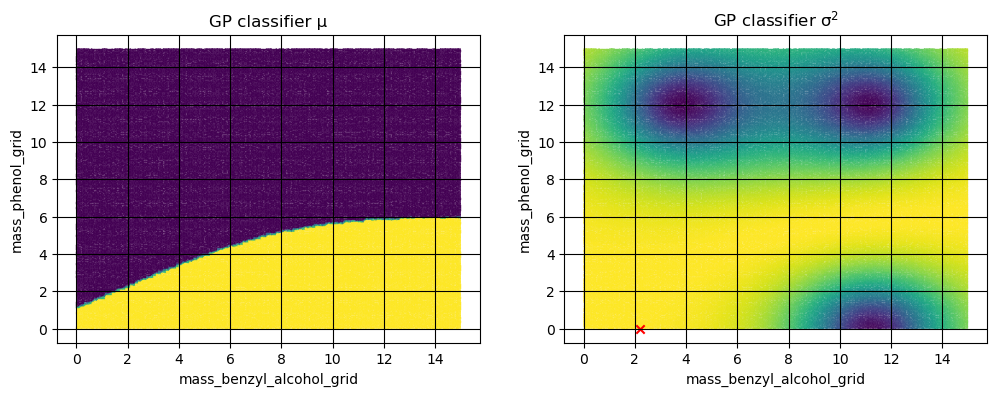

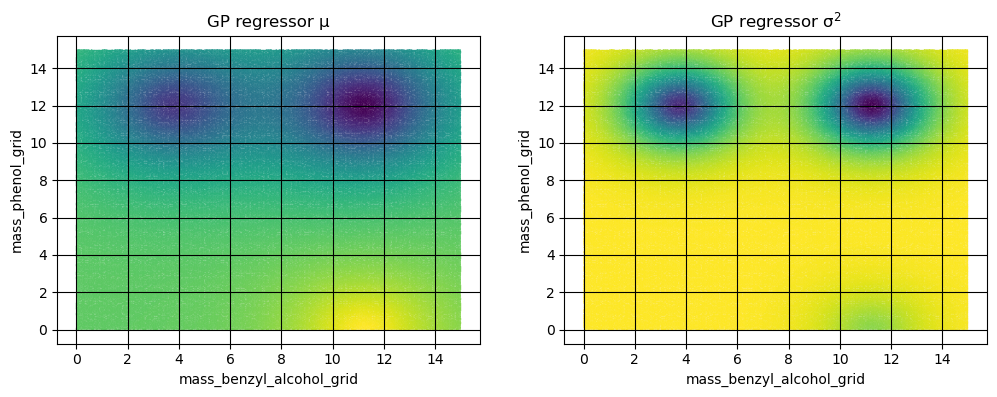

In [70]:
#declare the acquisition function scheme. Here is a combined iteration between low density and variance sampling
acq = AcquisitionFunction.IterationCombined(
    function1=AcquisitionFunction.Variance(),
    function2=AcquisitionFunction.LowestDensity(bandwidth=0.035),
    function2_frequency=5
)

acq.reset_phasemap(ds_AL)

#calculates the acquisition function
ds_AL = acq.calculate_metric(GP)

#supposedly checks that the data are within the bounds of the composition map
composition_check = ds_AL[ds_AL.attrs['components']]
if 'sample' in composition_check.indexes:
    composition_check = composition_check.reset_index('sample').reset_coords(drop=True)
composition_check = composition_check.to_array('component').transpose('sample',...)

#selects the next point to acquire
next_sample = acq.get_next_sample( composition_check = composition_check )



#plotting and evaluation of GPs
result_classifier = GP.predict(components=ds_AL.attrs['components_grid'])
result_regressor = GPR.predict(components=ds_AL.attrs['components_grid'])

fig,ax = plt.subplots(1,2,figsize=(12,4))
ds_AL['GPC_all_mean_1'] = (('grid','phase_num'),result_classifier['mean'])
ds_AL['GPC_all_var_1'] = (('grid','phase_num'),result_classifier['var'])
ds_AL['GPC_mean_1'] = ds_AL.GPC_all_mean_1.argmax('phase_num')
ds_AL['GPC_var_1'] = ds_AL.GPC_all_var_1.sum('phase_num')

ds_AL.afl.comp.plot_surface(ds_AL.attrs['components_grid'],labels='GPC_mean_1',ax=ax[0])
ds_AL.afl.comp.plot_surface(ds_AL.attrs['components_grid'],labels='GPC_var_1',ax=ax[1])
ax[1].scatter(*next_sample.values.T,color='red',marker='x')
ax[0].set(
    title='GP classifier μ'
)
ax[1].set(
    title='GP classifier σ$^{2}$'
)

fig,ax = plt.subplots(1,2,figsize=(12,4))
ds_AL['GPR_mean_1'] = ('grid',result_regressor['mean'].squeeze())
ds_AL['GPR_var_1'] = ('grid',result_regressor['var'].squeeze())
ds_AL.afl.comp.plot_surface(ds_AL.attrs['components_grid'],labels='GPR_mean_1',ax=ax[0])
ds_AL.afl.comp.plot_surface(ds_AL.attrs['components_grid'],labels='GPR_var_1',ax=ax[1])
ax[0].set(
    title='GP regressor μ'
)
ax[1].set(
    title='GP regressor σ$^{2}$'
)

#needs to have a "snap to" call in simulation land to grab the REAL data
nearest_real = np.linalg.norm(np.array([ds_GT['mass_benzyl_alcohol'],ds_GT['mass_phenol']]).T - np.expand_dims(next_sample,axis=0),axis=1)
next_real = ds_GT.sel(sample=np.argmin(nearest))
next_real['t_avg_scan'] = next_real['raw'].mean(dim='time')
next_real['labels'] = 0

ds_AL = xr.concat([ds_AL,next_real],dim='sample',data_vars='minimal')

# The Simulated Loop

In [7]:
# Re-establish the ground truth
ds_GT = xr.concat([ds_all_1,ds_all_2],dim='sample');

ch = ConvexHull(list(zip(ds_GT['mass_benzyl_alcohol'],ds_GT['mass_phenol'])))
delaunay = Delaunay(list(zip(ds_GT['mass_benzyl_alcohol'],ds_GT['mass_phenol'])))

xy = np.array([ds_GT['mass_benzyl_alcohol'],ds_GT['mass_phenol']]).T
sm = ds_GT[['mass_P188', 'mass_benzyl_alcohol','mass_phenol']].to_array('solutes').transpose('sample',...)
ds_GT['solute_masses'] = sm

reference = ds_GT.filtered_data_iqr.max(dim='sample').max(dim='time')
dark = np.ones(len(ds_GT.wavelength.values)) * np.random.normal(loc=0,scale = 7,size=len(ds_GT.wavelength.values))

ds_GT['median_of_timeseries'] = ds_GT.raw.median(dim='time')
ds_GT['median_transmittance_spectra'] = (('sample','wavelength'),(ds_GT.median_of_timeseries.values - dark)/(reference.values - dark))
ds_GT['median_transmittance_maxima'] = ds_GT['median_transmittance_spectra'].max(dim='wavelength')


ds_GT.attrs['components'] = ['mass_benzyl_alcohol','mass_phenol']
ds_GT.attrs['AL_data'] = 'median_transmittance_maxima'
ds_GT.attrs['input_uncert'] = 'std_of_maxima'
ds_GT.attrs['mass_benzyl_alcohol_range'] = (0,15)
ds_GT.attrs['mass_phenol_range'] = (0,15)

mask = delaunay.find_simplex(np.array([ds_GT['mass_benzyl_alcohol_grid'],ds_GT['mass_phenol_grid']]).T)>=0

ds_GT = ds_GT.afl.comp.add_grid(pts_per_row=51,overwrite=True)
ds_GT['grid_mask'] = (('grid','sample'),mask)
kernel = gpflow.kernels.Matern52(variance=0.5,lengthscales=2.0) + gpflow.kernels.White(1e-1)

GPR = HscedGaussianProcess.GPR(
    dataset = ds_GT,
    inputs = ds_GT['median'],
    uncertainties=ds_GT['IQR'],
    kernel=kernel
)

# GPR = GaussianProcess.GPR(
#     dataset=ds_GT,
#     kernel=kernel
# )
GPR.optimize(15,progress_bar=True)

result = GPR.predict(ds_GT.attrs['components_grid'])
ds_GT['GP_mean'] = ('grid',result['mean'].squeeze())
ds_GT['GP_var'] = ('grid',result['var'].squeeze())







#initialize the run
ds_AL = xr.concat([ds_GT.sel(sample=[5,6,13])],dim='sample')
ds_GT = ds_GT.drop_sel(sample=[5,6,13])


ds_AL = ds_AL.drop_vars(['mass_benzyl_alcohol_grid','mass_phenol_grid','GP_mean','GP_var',])
ds_AL = ds_AL.afl.comp.add_grid(pts_per_row=51,overwrite=True)

#setup the mask from the experimental data to the grid. In principle, this is determined fully by the composition ranges probed
mask = delaunay.find_simplex(np.array([ds_GT['mass_benzyl_alcohol_grid'],ds_GT['mass_phenol_grid']]).T)>=0
ds_AL['grid_mask'] = ('grid',mask)


#loop over remaining indices
for idx in range(len(ds_GT.sample.values)):
    print(idx)
    
    
    # similarity  metric and classification and plotting of data as it comes in
    ds_AL['t_avg_scan'] = ds_AL['raw'].mean(dim='time')
    # metric1 = Metric.Similarity('t_avg_scan',  name='t_avg_scan',  params=dict(metric='cosine'))
    # metric2 = Metric.Similarity('t_avg_scan',  name='t_avg_scan',  params=dict(metric='poly',gamma=1e-4,power=0.5))
    metric1 = Metric.Similarity('median_transmittance_spectra',  name='median_transmittance_spectra',  params=dict(metric='cosine'))
    metric2 = Metric.Similarity('median_transmittance_spectra',  name='median_transmittance_spectra',  params=dict(metric='poly',gamma=1e-4,power=0.5))

    metric1.calculate(ds_AL)
    metric2.calculate(ds_AL)

    metric = Metric.MultiMetric(
        [metric1,metric2],
        combine_by='sum',
        combine_by_powers=[1,1],
        combine_by_coeffs=[1,0],
        constrain_same=None,
        constrain_different=None,
    )
    metric.calculate(ds_AL)

    fig,ax = plt.subplots(2,2,figsize=(12,7),constrained_layout=True)
    mmap = ax[0][0].imshow(metric1.W,origin='lower')
    plt.colorbar(mappable=mmap,ax=ax[0][0])
    ax[0][0].set(
        xlabel = "sample",
        ylabel = "sample",
        title = "cosine similarity metric classification"
    )

    mmap = ax[0][1].imshow(metric2.W,origin='lower')
    plt.colorbar(mappable=mmap,ax=ax[0][1])
    ax[0][1].set(
        xlabel = "sample",
        ylabel = "sample",
        title = "polynomial similarity"
    )

    ds_AL['W'] = (('sample_i','sample_j'),metric.W)
    ds_AL.attrs['metric'] = str(metric.to_dict())
    labeler=PhaseLabeler.SpectralClustering()
    # labeler = PhaseLabeler.DBSCAN()
    labeler.label(ds_AL)
    print(f'Found {labeler.n_phases} phases!')
    ds_AL.attrs['n_phases'] = labeler.n_phases
    ds_AL['labels'] = ('sample',labeler.labels)

    ds_AL.afl.comp.plot_scatter(['mass_benzyl_alcohol','mass_phenol'],labels='labels',discrete_labels=True, s=200,ax=ax[1][0]);#,norm=norm);
    ax[1][0].set(
        title = 'classification',
        xlim=(-1,16),
        ylim=(-1,16),
        aspect=ax[0][0].get_aspect()
    )

    sc  = ds_AL.afl.comp.plot_scatter(['mass_benzyl_alcohol','mass_phenol'],labels='mean_of_maxima',discrete_labels=False, s=200,ax=ax[1][1]);#,norm=norm);
    cbar = plt.colorbar(sc,ax=ax[1][1])
    cbar.set_label(label='intensity AU',rotation=270,labelpad=15)

    ax[1][1].set(
        title = 'maximum intensity',
        xlim=(-1,16),
        ylim=(-1,16),
        aspect=ax[0][0].get_aspect()
    )
    # fig.savefig(f'SimulatedActiveLearningFigures/SimilarityAnalysis/SimilarityClassifiers-Clustering-Raw_iteration_{str(idx+1).zfill(3)}.svg',dpi=300)
    fig.savefig(f'SimulatedActiveLearningFigures/SimilarityAnalysis/SimilarityClassifiers-Clustering-Raw_iteration_{str(idx+1).zfill(3)}.png',dpi=300)
    plt.close(fig)


    #set up the GPs
    kernel_1 = gpflow.kernels.Matern52(variance=0.5,lengthscales=2.0) 
    GP = GaussianProcess.GP(
        dataset = ds_AL,
        kernel=kernel_1
    )

    kernel_2 = gpflow.kernels.Matern52(variance=0.5,lengthscales=2.0) + gpflow.kernels.White(1e-1)
    GPR = HscedGaussianProcess.GPR(
        dataset= ds_AL,
        inputs = ds_AL['median'],
        uncertainties=ds_AL['IQR'],
        kernel=kernel_2
    )
    # GPR = GaussianProcess()
    
    GP.optimize(15,progress_bar=True)
    GPR.optimize(15,progress_bar=True)







  #set up the acquisition function and select the next sample
    acq = AcquisitionFunction.IterationCombined(
        function1=AcquisitionFunction.Variance(),
        function2=AcquisitionFunction.LowestDensity(bandwidth=0.035),
        function2_frequency=5
    )
    
    #pseudoUCB
    # acq = UCB_AcquisitionFunction.pseudoUCB()

    acq.reset_phasemap(ds_AL)

    #calculates the acquisition function
    ds_AL = acq.calculate_metric(GP)
    # ds_AL = acq.calculate_metric(GP=GP,GPR=GPR,scaling=1,thompson_sampling=True)

    #supposedly checks that the data are within the bounds of the composition map
    composition_check = ds_AL[ds_AL.attrs['components']]
    if 'sample' in composition_check.indexes:
        composition_check = composition_check.reset_index('sample').reset_coords(drop=True)
    composition_check = composition_check.to_array('component').transpose('sample',...)

    #selects the next point to acquire (with the classifier it is argmax(),)
    next_sample = acq.get_next_sample( composition_check = composition_check )



    #plotting and evaluation of GPs
    result_classifier = GP.predict(components=ds_AL.attrs['components_grid'])
    result_regressor = GPR.predict(components=ds_AL.attrs['components_grid'])

    fig,ax = plt.subplots(1,2,figsize=(12,4))
    # ds_AL['GPC_all_mean_1'] = (('grid','phase_num'),result_classifier['mean'])
    # ds_AL['GPC_all_var_1'] = (('grid','phase_num'),result_classifier['var'])
    # ds_AL['GPC_mean_1'] = ds_AL.GPC_all_mean_1.argmax('phase_num')
    # ds_AL['GPC_var_1'] = ds_AL.GPC_all_var_1.sum('phase_num')
    
    ds_AL['GPC_mean_1'] = np.argmax(result_classifier['mean'],axis=1)
    ds_AL['GPC_var_1'] = np.sum(result_classifier['var'],axis=1)

    ds_AL.afl.comp.plot_surface(ds_AL.attrs['components_grid'],labels='GPC_mean_1',ax=ax[0])
    ds_AL.afl.comp.plot_surface(ds_AL.attrs['components_grid'],labels='GPC_var_1',ax=ax[1])
    ax[1].scatter(*next_sample.values.T,color='red',marker='x')
    ax[0].set(
        title='GP classifier μ'
    )
    ax[1].set(
        title='GP classifier σ$^{2}$'
    )
    # fig.savefig(f'SimulatedActiveLearningFigures/GPClassifier/GPClassifierMeanAndVariance_iteration_{str(idx+1).zfill(3)}.svg',dpi=300)
    # fig.savefig(f'SimulatedActiveLearningFigures/GPClassifier/GPClassifierMeanAndVariance_iteration_{str(idx+1).zfill(3)}.png',dpi=300)
    plt.close(fig)

    fig,ax = plt.subplots(1,2,figsize=(12,4))
    ds_AL['GPR_mean_1'] = ('grid',result_regressor['mean'].squeeze())
    ds_AL['GPR_var_1'] = ('grid',result_regressor['var'].squeeze())
    ds_AL.afl.comp.plot_surface(ds_AL.attrs['components_grid'],labels='GPR_mean_1',ax=ax[0])
    ds_AL.afl.comp.plot_surface(ds_AL.attrs['components_grid'],labels='GPR_var_1',ax=ax[1])
    ax[0].scatter(*next_sample.values.T,color='red',marker='x')
    ax[0].set(
        title='GP regressor μ'
    )
    ax[1].set(
        title='GP regressor σ$^{2}$'
    )
    # fig.savefig(f'SimulatedActiveLearningFigures/GPRegressor/GPRegressorMeanAndVariance_iteration_{str(idx+1).zfill(3)}.svg',dpi=300)
    # fig.savefig(f'SimulatedActiveLearningFigures/GPRegressor/GPRegressorMeanAndVariance_iteration_{str(idx+1).zfill(3)}.png',dpi=300)
    plt.close(fig)
    
    #needs to have a "snap to" call in simulation land to grab the REAL data
    nearest_real = np.linalg.norm(np.array([ds_GT['mass_benzyl_alcohol'],ds_GT['mass_phenol']]).T - np.expand_dims(next_sample,axis=0),axis=1)
    next_real = ds_GT.sel(sample=np.argmin(nearest_real))
    next_real['t_avg_scan'] = next_real['raw'].mean(dim='time')
    next_real['labels'] = 0
    
    ds_AL = xr.concat([ds_AL,next_real],dim='sample',data_vars='minimal')
    ds_GT = ds_GT.drop_sel(sample=np.argmin(nearest_real))

--> Making grid for components ['mass_benzyl_alcohol', 'mass_phenol'] at 51 pts_per_row
{'mass_benzyl_alcohol': {'min': 0, 'max': 15, 'steps': 51}, 'mass_phenol': {'min': 0, 'max': 15, 'steps': 51}}


  0%|          | 0/2601 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 19.56it/s]


--> Making grid for components ['mass_benzyl_alcohol', 'mass_phenol'] at 51 pts_per_row
{'mass_benzyl_alcohol': {'min': 0, 'max': 15, 'steps': 51}, 'mass_phenol': {'min': 0, 'max': 15, 'steps': 51}}


  0%|          | 0/2601 [00:00<?, ?it/s]

0
Found 2 phases!


  0%|                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 16.97it/s]


Using acquisition function variance of iteration 1


KeyboardInterrupt: 

In [80]:
import glob
from PIL import Image
def make_gif(frame_folder='path/to/frames',filetype='png',gif_name='gif'):
    frames = [Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*.{filetype}"))]
    frame_one = frames[0]
    frame_one.save(f"{gif_name}.gif", format="GIF", append_images=frames,
               save_all=True, duration=100, loop=0)
    
path_to_files = ['SimulatedActiveLearningFigures/GPClassifier/','SimulatedActiveLearningFigures/GPRegressor/','SimulatedActiveLearningFigures/SimilarityAnalysis/']
for path in path_to_files:
    make_gif(path,gif_name=f"{os.path.basename(path[:-1])}_Transmittance_classifier")

In [207]:
ds_GT

<xarray.Dataset>
Dimensions:                   (time: 98, wavelength: 2047, sample: 59,
                               solutes: 3, grid: 22801)
Coordinates:
  * time                      (time) float64 0.0 0.102 0.1021 ... 4.898 4.9 5.0
  * wavelength                (wavelength) float64 181.2 181.5 ... 867.7 867.9
  * solutes                   (solutes) object 'mass_P188' ... 'mass_phenol'
Dimensions without coordinates: sample, grid
Data variables: (12/18)
    raw                       (sample, time, wavelength) float64 110.0 ... 121.0
    filtered_data_iqr         (sample, time, wavelength) float64 110.0 ... 121.0
    mean_of_maxima            (sample) float64 3.139e+03 165.2 ... 1.25e+03
    std_of_maxima             (sample) float64 264.3 3.59 188.8 ... 208.5 271.5
    filtered_data_1std        (sample, time, wavelength) float64 110.0 ... 121.0
    maxima                    (sample, time) float64 3.241e+03 nan ... 1.188e+03
    ...                        ...
    solute_masses             (sample, solutes) float64 10.0 0.0 ... 9.358 8.5
    GP_mean                   (grid) float64 0.1422 0.1499 ... -0.07198 -0.06824
    GP_var                    (grid) float64 0.5866 0.5846 ... 0.6011 0.6013
    mass_benzyl_alcohol_grid  (grid) float64 0.0 0.0 0.0 0.0 ... 15.0 15.0 15.0
    mass_phenol_grid          (grid) float64 0.0 0.1 0.2 0.3 ... 14.8 14.9 15.0
    grid_mask                 (grid, sample) bool False False ... False False
Attributes:
    components:                      ['mass_benzyl_alcohol', 'mass_phenol']
    AL_data:                         mean_of_maxima
    input_uncert:                    std_of_maxima
    mass_benzyl_alcohol_range:       (0, 15)
    mass_phenol_range:               (0, 15)
    components_grid:                 ['mass_benzyl_alcohol_grid', 'mass_pheno...
    mass_benzyl_alcohol_grid_range:  (0, 15)
    mass_phenol_grid_range:          (0, 15)

(8, 59)
(30, 48)
(22, 4)
(15, 25)
(13, 70)


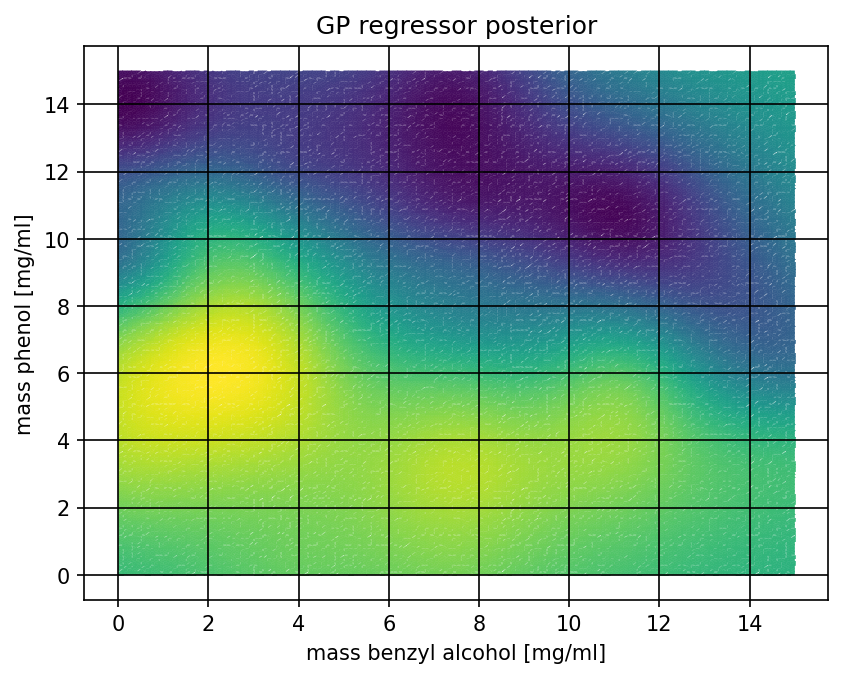

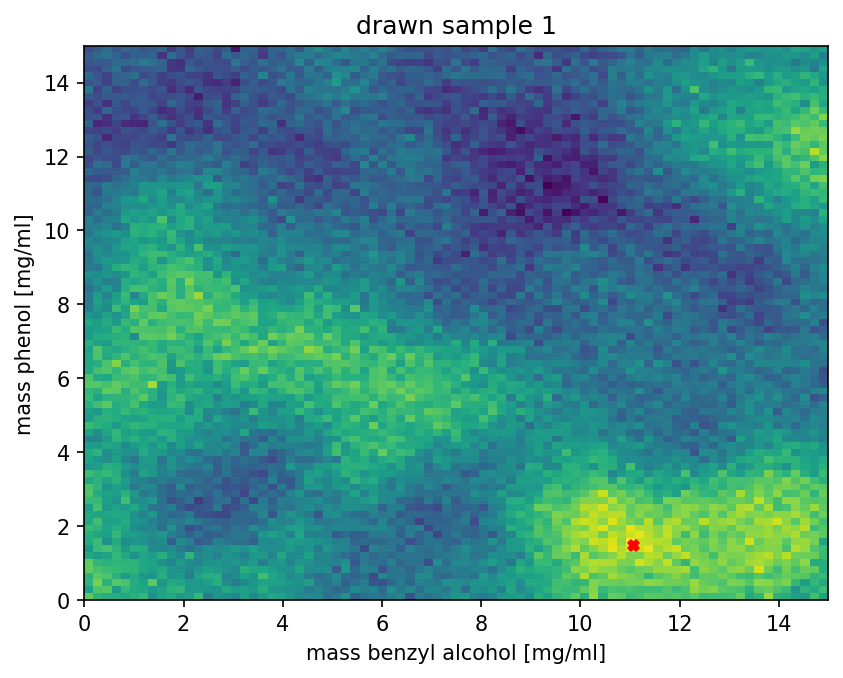

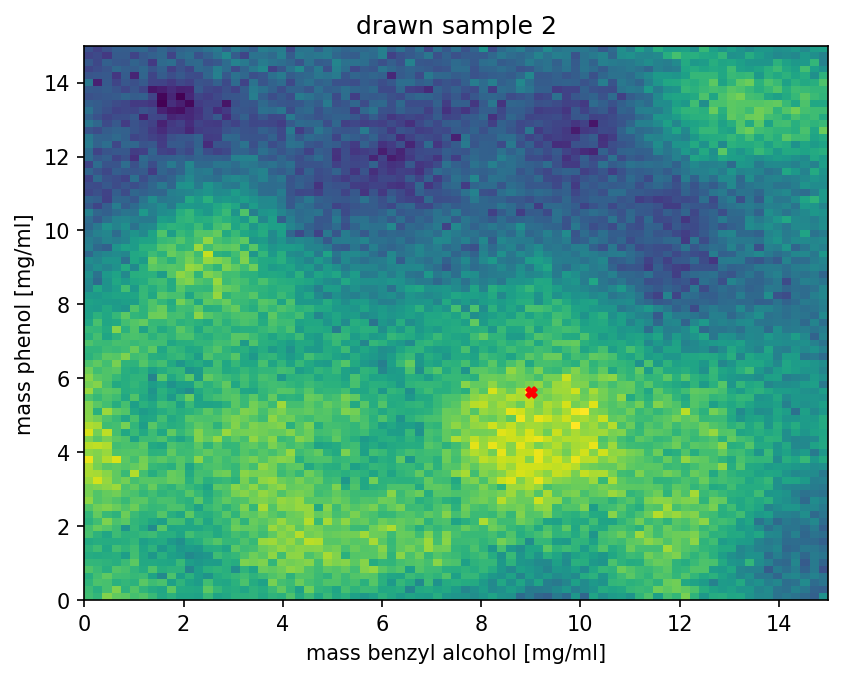

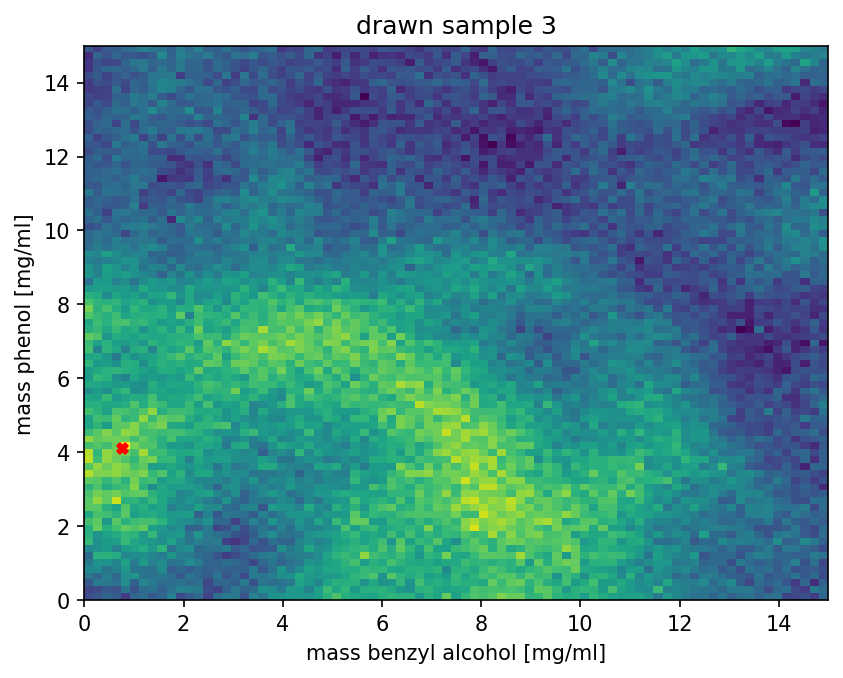

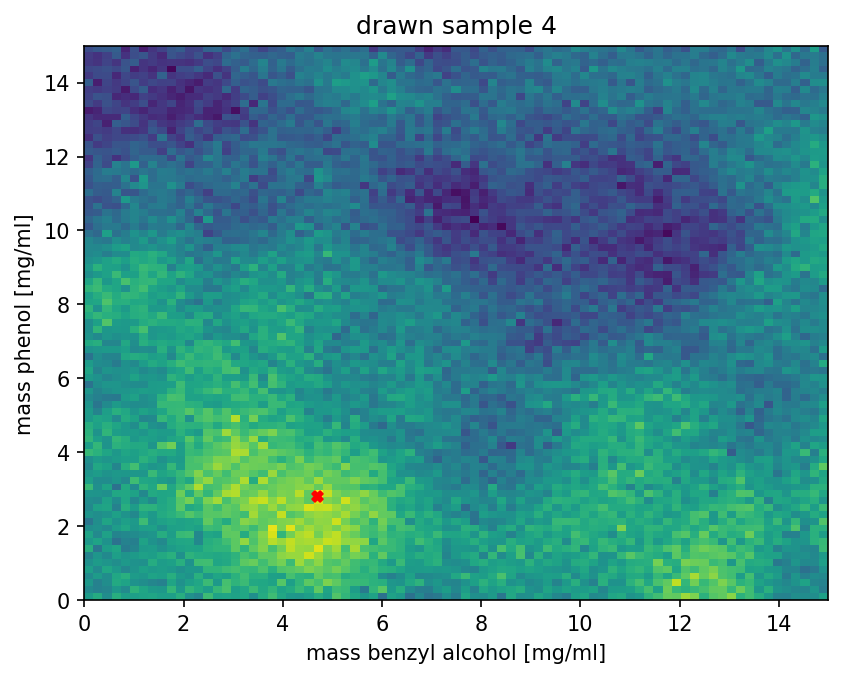

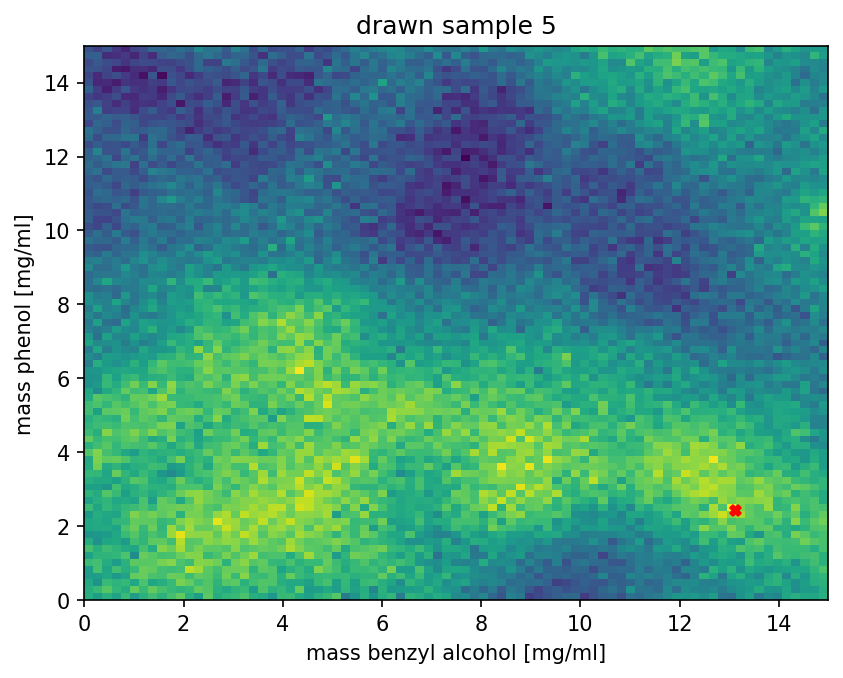

In [201]:
xy = np.array([ds_AL['mass_benzyl_alcohol_grid'],ds_AL['mass_phenol_grid']]).T
xx,yy = np.meshgrid(np.linspace(0,15,81),np.linspace(0,15,81))
xy = np.stack([xx.ravel(),yy.ravel()],axis=1)

samps = GPR.model.predict_f_samples(xy,5)
fig,ax = plt.subplots(dpi=150)
ds_AL.afl.comp.plot_surface(ds_AL.attrs['components_grid'],labels='GPR_mean_1',ax=ax)
ax.set(
    xlabel='mass benzyl alcohol [mg/ml]',
    ylabel='mass phenol [mg/ml]',
    title=f'GP regressor posterior'
)

for i, p in enumerate(samps):
    img = p.reshape(81,81)
    argmax = np.argmax(p)
    ij = np.unravel_index(argmax,img.shape)
    print(ij)
    fig,ax = plt.subplots(dpi=150)
    ax.imshow(img,aspect='auto',origin='lower',extent=[0,15,0,15])
    ax.scatter(xy[argmax][0],xy[argmax][1],s=25,marker='X',c='r')
    ax.set(
        xlabel='mass benzyl alcohol [mg/ml]',
        ylabel='mass phenol [mg/ml]',
        title=f'drawn sample {i+1}'
    )

In [9]:
ds_GT

<xarray.Dataset>
Dimensions:                   (time: 98, wavelength: 2047, sample: 62,
                               solutes: 3, grid: 2601)
Coordinates:
  * time                      (time) float64 0.0 0.102 0.1021 ... 4.898 4.9 5.0
  * wavelength                (wavelength) float64 181.2 181.5 ... 867.7 867.9
  * solutes                   (solutes) object 'mass_P188' ... 'mass_phenol'
Dimensions without coordinates: sample, grid
Data variables: (12/18)
    raw                       (sample, time, wavelength) float64 110.0 ... 121.0
    filtered_data_iqr         (sample, time, wavelength) float64 110.0 ... 121.0
    mean_of_maxima            (sample) float64 3.139e+03 165.2 ... 1.25e+03
    std_of_maxima             (sample) float64 264.3 3.59 188.8 ... 208.5 271.5
    filtered_data_1std        (sample, time, wavelength) float64 110.0 ... 121.0
    maxima                    (sample, time) float64 3.241e+03 nan ... 1.188e+03
    ...                        ...
    solute_masses             (sample, solutes) float64 10.0 0.0 ... 9.358 8.5
    GP_mean                   (grid) float64 0.1422 0.1664 ... -0.07995 -0.06824
    GP_var                    (grid) float64 0.5866 0.5798 ... 0.6005 0.6013
    mass_benzyl_alcohol_grid  (grid) float64 0.0 0.0 0.0 0.0 ... 15.0 15.0 15.0
    mass_phenol_grid          (grid) float64 0.0 0.3 0.6 0.9 ... 14.4 14.7 15.0
    grid_mask                 (grid, sample) bool False False ... False False
Attributes:
    components:                      ['mass_benzyl_alcohol', 'mass_phenol']
    AL_data:                         mean_of_maxima
    input_uncert:                    std_of_maxima
    mass_benzyl_alcohol_range:       (0, 15)
    mass_phenol_range:               (0, 15)
    components_grid:                 ['mass_benzyl_alcohol_grid', 'mass_pheno...
    mass_benzyl_alcohol_grid_range:  (0, 15)
    mass_phenol_grid_range:          (0, 15)

## Raw Spectrometer data to Absorbance/Transmittance data

(400.0, 800.0)

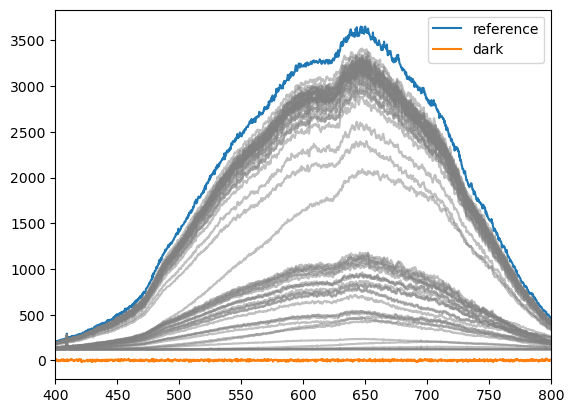

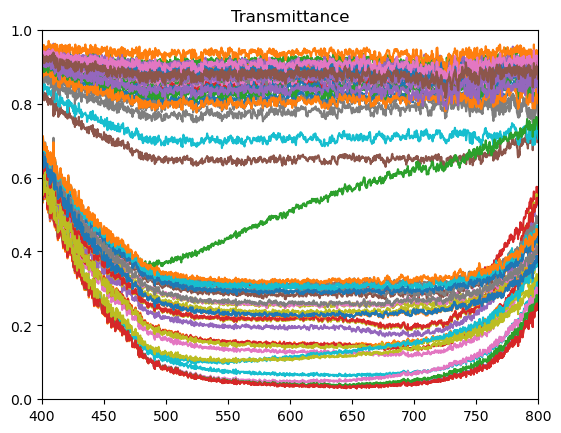

In [20]:
from scipy.signal import savgol_filter
reference = ds_GT.filtered_data_iqr.max(dim='sample').max(dim='time')
dark = np.ones(len(ds_GT.wavelength.values)) * np.random.normal(loc=0,scale = 7,size=len(ds_GT.wavelength.values))
plt.figure()
plt.plot(ds_GT.wavelength.values,reference,label='reference')
plt.plot(ds_GT.wavelength.values,dark+1,label='dark')
plt.plot(ds_GT.wavelength.values,ds_GT.raw.median(dim='time').T,c='gray',alpha=0.5)
plt.legend()
plt.xlim(400,800)

ds_GT['median_of_timeseries'] = ds_GT.raw.median(dim='time')
# ds_GT['median_of_timeseries'].values.shape
ds_GT['median_transmittance'] = (('sample','wavelength'),(ds_GT.median_of_timeseries.values - dark)/(reference.values - dark))
# plt.plot(ds_GT.wavelength.values,ds_GT['median_of_timeseries'].values.T)
# ds_GT['median_absorbance'] = ds_GT['median_of_timeseries']
plt.figure()
plt.title('Transmittance')
plt.plot(ds_GT.wavelength.values, savgol_filter(ds_GT.median_transmittance.values.T,window_length=3,polyorder=2))
plt.ylim(0,1)
plt.xlim(400,800)

In [90]:
ds_GT['median_transmittance_spectra'].sel(wavelength=np.linspace(450,650,100),method='nearest')

<xarray.DataArray 'median_transmittance_spectra' (sample: 0, wavelength: 100)>
array([], shape=(0, 100), dtype=float64)
Coordinates:
  * wavelength  (wavelength) float64 450.1 451.9 454.0 ... 646.1 648.0 650.0
Dimensions without coordinates: sample

14.175